In [1]:
import random
import threading
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from parameters import *
from utils import next_train, initialization, get_next_starting_Time, get_ActiveSchedule, get_df_ofPassengers, arrival_time

### 原封不动、贪心算法、退火算法的结果比较

In [2]:
df=pd.read_csv('../shenzhen_data/morning_longtime_100000(processed).csv')
df.drop_duplicates(inplace=True)
print(df.shape, df.columns)
df.sort_values(by=['time'], inplace=True)
df['time']=df['time']+2*int(stations_N*2*(skipped_saved+station_interval)) # 提前一定时间开始运营地铁，发出的第一台车跑完一圈就开始接待高峰期乘客
print(passenger_max)
df.head(2)

(10000, 7) Index(['start', 'end', 'time', 'id', 'forward', 'start_', 'end_'], dtype='object')
75


,start,end,time,id,forward,start_,end_
6415,18,7,270,59806,0,31,42
4936,23,13,270,94603,0,26,36


In [3]:
df_schedule1=pd.read_csv('../result/df_schedule_al1.csv')
df_schedule_SA1=pd.read_csv('../result/df_schedule_al1_SA.csv', index_col=0)
df_schedule_ref=pd.read_csv('../result/df_schedule_ref.csv',index_col=0)

df_schedule2=pd.read_csv('../result/df_schedule_al2.csv')
df_schedule_SA2=pd.read_csv('../result/df_schedule_al2_SA.csv', index_col=0)

df_schedule3=pd.read_csv('../result/df_schedule_al3.csv')
df_schedule_SA3=pd.read_csv('../result/df_schedule_al3_SA.csv', index_col=0)

In [4]:
def calculating_waiting_time_for_SA(df_schedule, df,result_t=None, result_df=None):
    waiting_time=0
    waiting_time_list=[]
    station_interval_list=[]
    df_changing=df.copy()
    df_schedule_temp=pd.DataFrame()
    for i in range(df_schedule.shape[0]):
        temp_schedule=df_schedule.iloc[[i]]
        stop_stations=temp_schedule.T.reset_index()[stations_N*2:stations_N*4][i].values
        df_schedule_temp=pd.concat([df_schedule_temp, temp_schedule])
        df_drop, _=get_df_ofPassengers(next_schedule_Ref=temp_schedule, stop_stations=stop_stations.copy(), df_changing=df_changing.copy()) # 新车把旧车接走了
        if len(df_drop)!=0:
            waiting_time_list.append(df_drop.apply(lambda row: arrival_time(row['start_'], row['end_'], row['time'],df_schedule=temp_schedule)[1], axis=1))
            waiting_time+=waiting_time_list[-1].sum()
            station_interval_list.append(list(df_drop['end_']-df_drop['start_']))

        df_changing=pd.merge(df_changing, df_drop, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
        # print("stop_stations:", stop_stations)

    #
    while df_changing.shape[0]>0:
        print('a new shcedule is generated')
        stop_stations=list(np.ones(stations_N*2).astype(int))
        StartTrain_time=df_schedule_temp['restart_time'].iloc[-train_N:].min()  # 已经在运行列车最早回来的值
        temp_schedule=next_train(stop_stations=stop_stations, StartTrain_time=StartTrain_time)
        df_schedule_temp=pd.concat([df_schedule_temp, temp_schedule])
        df_schedule_temp.reset_index(drop=True, inplace=True)
        df_drop, _=get_df_ofPassengers(next_schedule_Ref=temp_schedule, stop_stations=stop_stations.copy(), df_changing=df_changing.copy()) # 新车把旧车接走了
        if len(df_drop)!=0:
            waiting_time_list.append(df_drop.apply(lambda row: arrival_time(row['start_'], row['end_'], row['time'],df_schedule=temp_schedule)[1], axis=1))
            waiting_time+=waiting_time_list[-1].sum()
            station_interval_list.append(list(df_drop['end_']-df_drop['start_']))

        df_changing=pd.merge(df_changing, df_drop, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
#         print("stop_stations:", stop_stations)
        
    df_schedule_temp.reset_index(drop=True, inplace=True)
    
    if result_t!=None:
        result_t.append(waiting_time)
        result_df.append(df_schedule)
    return waiting_time, df_schedule_temp, station_interval_list,waiting_time_list

In [5]:
a,b,c,d=calculating_waiting_time_for_SA(df_schedule_ref.copy(),df.copy())

In [6]:
a_1,b_1,c_1,d_1=calculating_waiting_time_for_SA(df_schedule1.copy(),df.copy())

In [7]:
a_2,b_2,c_2,d_2=calculating_waiting_time_for_SA(df_schedule_SA1.copy(),df.copy())

In [8]:
a_3,b_3,c_3,d_3=calculating_waiting_time_for_SA(df_schedule2.copy(),df.copy())

In [9]:
a_4,b_4,c_4,d_4=calculating_waiting_time_for_SA(df_schedule_SA2.copy(),df.copy())

In [10]:
a_5,b_5,c_5,d_5=calculating_waiting_time_for_SA(df_schedule3.copy(),df.copy())

In [11]:
a_6,b_6,c_6,d_6=calculating_waiting_time_for_SA(df_schedule_SA3.copy(),df.copy())

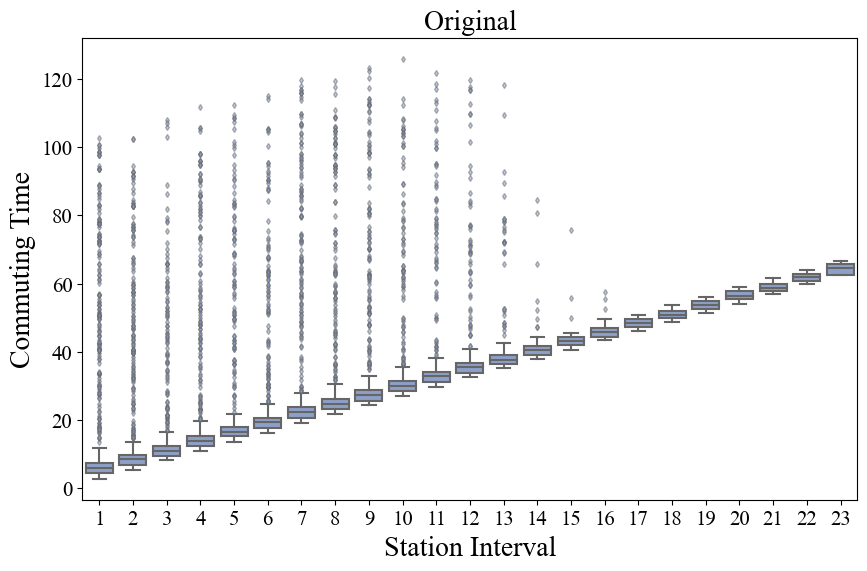

In [12]:
import seaborn as sns
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(10, 6))
sns.boxplot(x=[item for sublist in c for item in sublist], y=[item for sublist in d for item in sublist], color='#839DD1', flierprops=dict(alpha=0.5,markerfacecolor='#839DD1',markersize=3))
plt.xlabel('Station Interval',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Commuting Time',fontsize=20)
plt.yticks(fontsize=15)

plt.title('Original',fontsize=20)
# plt.box(False)
plt.show()

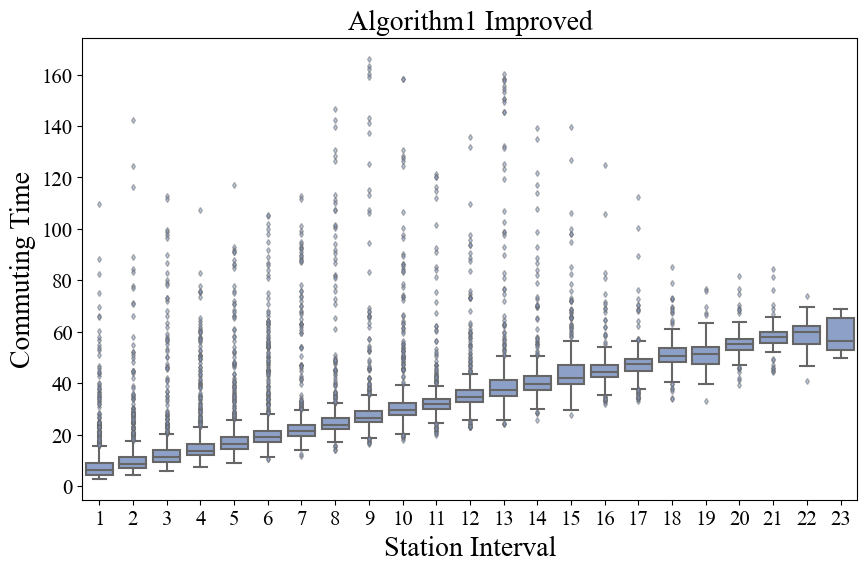

In [13]:
import seaborn as sns
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(10, 6))
sns.boxplot(x=[item for sublist in c_1 for item in sublist], y=[item for sublist in d_1 for item in sublist], color='#839DD1', flierprops=dict(alpha=0.5,markerfacecolor='#839DD1',markersize=3))
plt.xlabel('Station Interval',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Commuting Time',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Algorithm1 Improved',fontsize=20)
# plt.box(False)
plt.show()

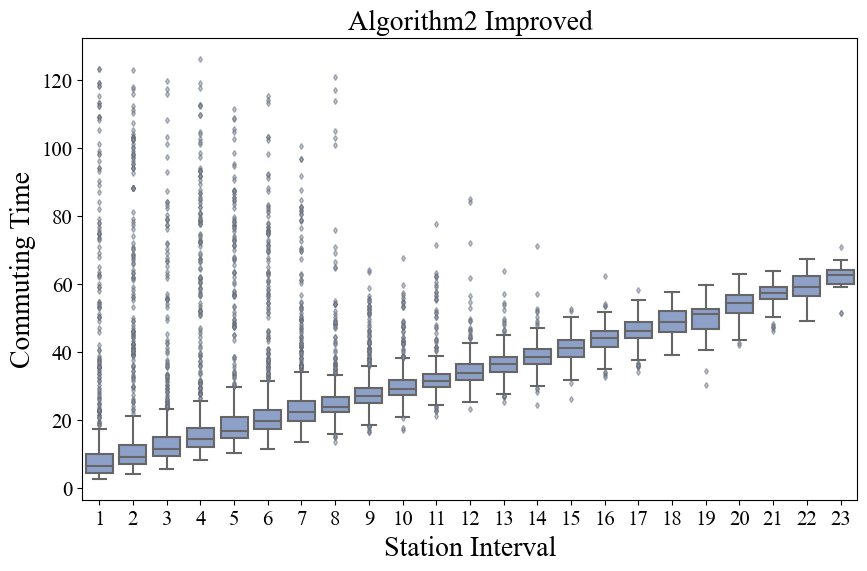

In [14]:
import seaborn as sns
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(10, 6))
sns.boxplot(x=[item for sublist in c_3 for item in sublist], y=[item for sublist in d_3 for item in sublist], color='#839DD1', flierprops=dict(alpha=0.5,markerfacecolor='#839DD1',markersize=3))
plt.xlabel('Station Interval',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Commuting Time',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Algorithm2 Improved',fontsize=20)
# plt.box(False)
plt.show()

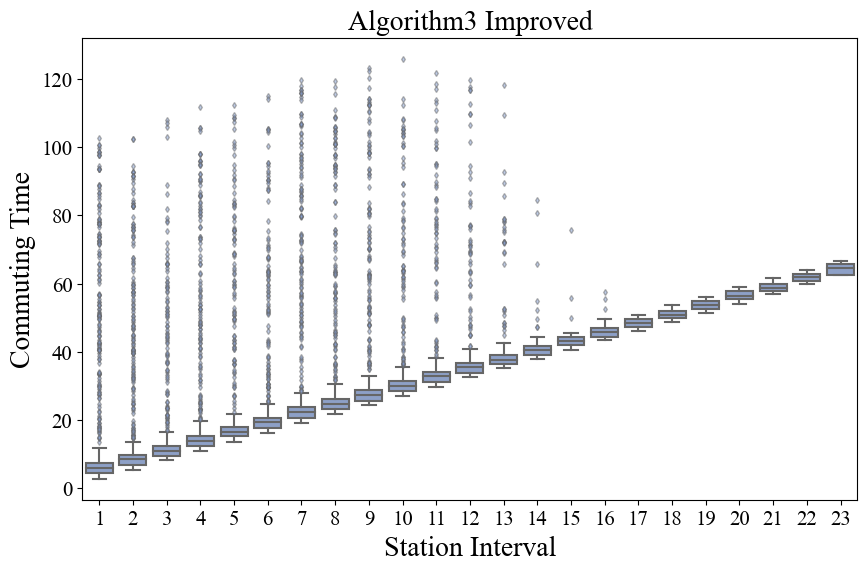

In [15]:
import seaborn as sns
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(10, 6))
sns.boxplot(x=[item for sublist in c_5 for item in sublist], y=[item for sublist in d_5 for item in sublist], color='#839DD1', flierprops=dict(alpha=0.5,markerfacecolor='#839DD1',markersize=3))
plt.xlabel('Station Interval',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Commuting Time',fontsize=20)
plt.yticks(fontsize=15)
plt.title('Algorithm3 Improved',fontsize=20)
# plt.box(False)
plt.show()

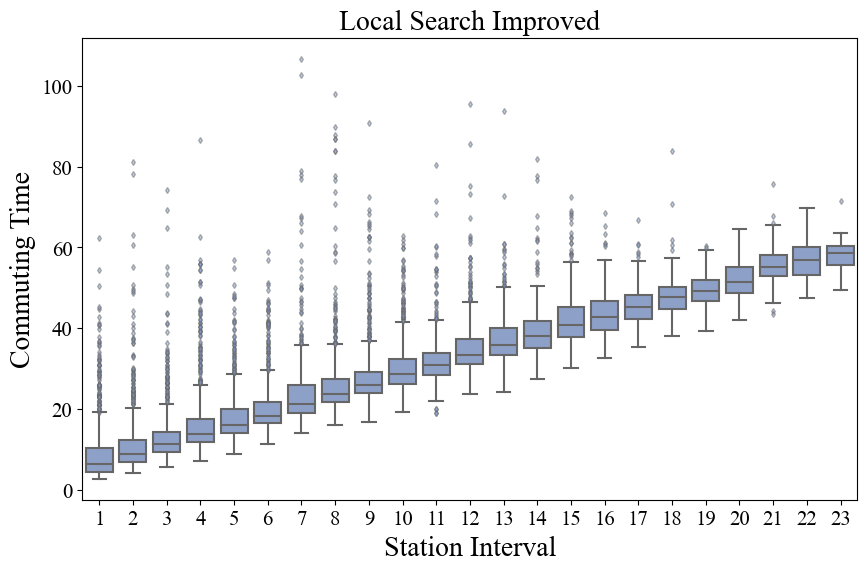

In [16]:
import seaborn as sns
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['boxplot.flierprops.markersize'] = 0.1
plt.figure(figsize=(10, 6))
sns.boxplot(x=[item for sublist in c_2 for item in sublist], y=[item for sublist in d_2 for item in sublist], color='#839DD1', flierprops=dict(alpha=0.5,markerfacecolor='#839DD1',markersize=3))
plt.xlabel('Station Interval',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Commuting Time',fontsize=20)
plt.yticks(fontsize=15)

plt.title('Local Search Improved',fontsize=20)
# plt.box(False)
plt.show()

### 横向对比：

1. station interval=2

In [17]:
# np.sum([item for sublist in c for item in sublist])
x=[item for sublist in c for item in sublist]
y=[item for sublist in d for item in sublist]

x1=[item for sublist in c_1 for item in sublist]
y1=[item for sublist in d_1 for item in sublist]

x2=[item for sublist in c_2 for item in sublist]
y2=[item for sublist in d_2 for item in sublist]

temp=pd.DataFrame({'x':x,'y':y})
temp1=pd.DataFrame({'x':x1,'y':y1})
temp2=pd.DataFrame({'x':x2,'y':y2})

Text(0.5, 1.0, 'Commuting Time for Station Interval = 2')

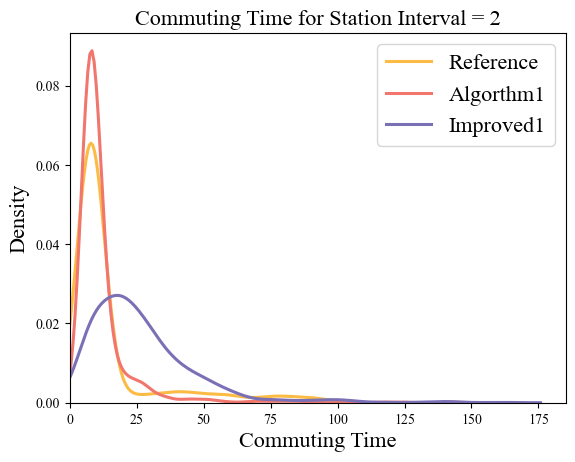

In [22]:
sns.kdeplot(temp[temp['x']==2]['y'],color='#FCBB44',linewidth=2.2, label='Reference')
sns.kdeplot(temp1[temp1['x']==2]['y'],color='#F1766D',linewidth=2.2, label='Algorthm1')
sns.kdeplot(temp1[temp2['x']==2]['y'],color='#7A70B5',linewidth=2.2, label='Improved1')
plt.xlim(0, plt.xlim()[1])
plt.legend(fontsize=16)
plt.xlabel('Commuting Time', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Commuting Time for Station Interval = 2',fontsize=16)

Text(0.5, 1.0, 'Commuting Time for Station Interval = 9')

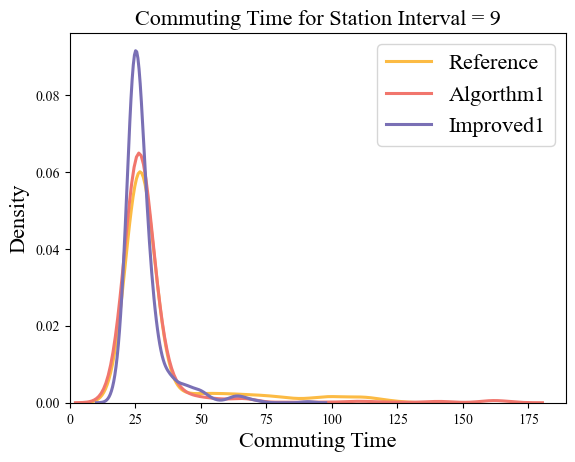

In [23]:
sns.kdeplot(temp[temp['x']==9]['y'],color='#FCBB44',linewidth=2.2, label='Reference')
sns.kdeplot(temp1[temp1['x']==9]['y'],color='#F1766D',linewidth=2.2, label='Algorthm1')
sns.kdeplot(temp2[temp2['x']==9]['y'],color='#7A70B5',linewidth=2.2, label='Improved1')
plt.xlim(0, plt.xlim()[1])
plt.legend(fontsize=16)
plt.xlabel('Commuting Time', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Commuting Time for Station Interval = 9',fontsize=16)

Text(0, 0.5, 'Density')

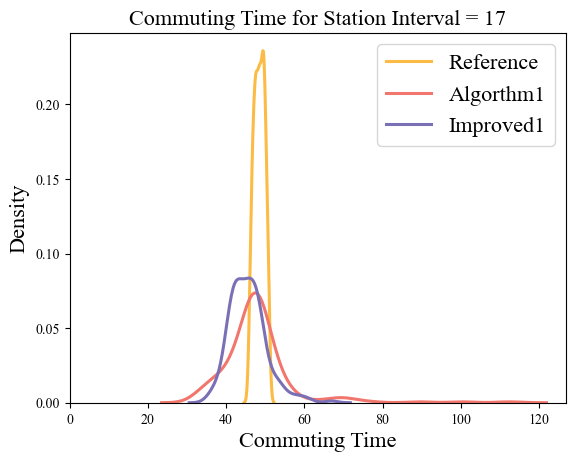

In [25]:
sns.kdeplot(temp[temp['x']==17]['y'],color='#FCBB44',linewidth=2.2, label='Reference')
sns.kdeplot(temp1[temp1['x']==17]['y'],color='#F1766D',linewidth=2.2, label='Algorthm1')
sns.kdeplot(temp2[temp2['x']==17]['y'],color='#7A70B5',linewidth=2.2, label='Improved1')
plt.xlim(0, plt.xlim()[1])
plt.legend(fontsize=16)
plt.title('Commuting Time for Station Interval = 17',fontsize=16)
plt.xlabel('Commuting Time', fontsize=16)
plt.ylabel('Density', fontsize=16)

## 同理，能够画出对于其他情况的violin plot

In [111]:
# import matplotlib.pyplot as plt

# # 示例数据
# x = ['algorithm1','algorithm2','algorithm3']
# y1 = [a,a,a]
# y2 = [a_1,a_3,a_5]
# y3 = [a_2,a_4,a_6]

# bar_width = 0.25
# bar_gap = 0.05

# # 绘制柱状图
# plt.figure(figsize=(10,5))
# plt.bar(np.arange(len(x)), y1, width=bar_width, label='algorithm 1-2',color='#FCBB44')
# plt.bar(np.arange(len(x)) + bar_width , y2, width=bar_width, label='algorithm 1-3',color='#F1766D')
# plt.bar(np.arange(len(x)) + 2 * (bar_width ), y3, width=bar_width, label='algorithm 2-3',color='#7A70B5')

# # 设置x轴刻度
# plt.xticks(np.arange(len(x)) + bar_width, x)

# # 添加标签、标题和图例
# plt.xlabel('number of people waiting for subway',fontsize=16)
# plt.ylabel('Hamington Distance',fontsize=16)
# plt.title('Bar Chart',fontsize=20)
# plt.xticks(fontsize=14)
# plt.legend()

# plt.show()


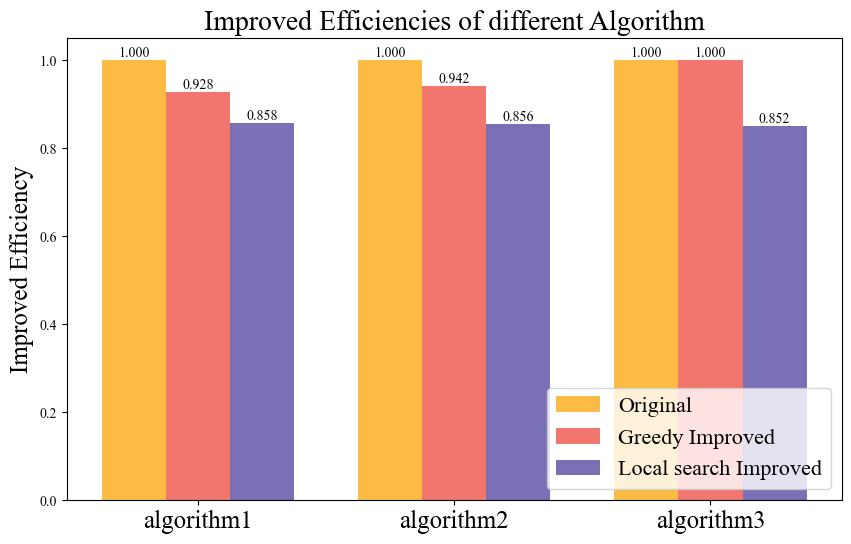

In [155]:
import matplotlib.pyplot as plt

# 示例数据
x = ['algorithm1','algorithm2','algorithm3']
y1 = [1,1,1]
y2 = [a_1/a,a_3/a,a_5/a]
y3 = [a_2/a,a_4/a,a_6/a]

bar_width = 0.25
bar_gap = 0.05

plt.figure(figsize=(10, 6))
# plt.bar(np.arange(len(x)), y1, width=bar_width, label='Original')
# plt.bar(np.arange(len(x)) + bar_width, y2, width=bar_width, label='Greedy Improved')
# plt.bar(np.arange(len(x)) + 2 * (bar_width), y3, width=bar_width, label='simulated annealing improved')

plt.bar(np.arange(len(x)), y1, width=bar_width, label='Original',color='#FCBB44')
plt.bar(np.arange(len(x)) + bar_width , y2, width=bar_width, label='Greedy Improved',color='#F1766D')
plt.bar(np.arange(len(x)) + 2 * (bar_width ), y3, width=bar_width, label='Local search Improved',color='#7A70B5')

# 设置每个柱子上显示的值，并保留两位小数
for i, v in enumerate(y1):
    plt.text(i, v , '{:.3f}'.format(v), ha='center', va='bottom')
for i, v in enumerate(y2):
    plt.text(i + bar_width, v , '{:.3f}'.format(v), ha='center', va='bottom')
for i, v in enumerate(y3):
    plt.text(i + 2 * bar_width, v , '{:.3f}'.format(v), ha='center', va='bottom')

# 设置x轴刻度
plt.xticks(np.arange(len(x)) + bar_width, x,fontsize=18)
# plt.xlabel('number of people waiting for subway',fontsize=16)
plt.ylabel('Improved Efficiency',fontsize=18)
plt.title('Improved Efficiencies of different Algorithm',fontsize=20)
plt.legend(fontsize=16,loc='lower right')
plt.show()


## 模拟退火过程展示

In [121]:
df_SA_process1=pd.read_csv('../result/SA_al1_process.csv',index_col=0)
df_SA_process2=pd.read_csv('../result/SA_al2_process.csv',index_col=0)
df_SA_process3=pd.read_csv('../result/SA_al3_process.csv',index_col=0)

In [122]:
def lowerbound(array_):
    temp=[array_[0]]
    for i in range(len(array_)-1):
        if array_[i+1]<temp[-1]:
            temp.append(array_[i+1])
        else:
            temp.append(temp[-1])
    return temp

Text(0.5, 1.0, 'Local Search Process after Algorithm1')

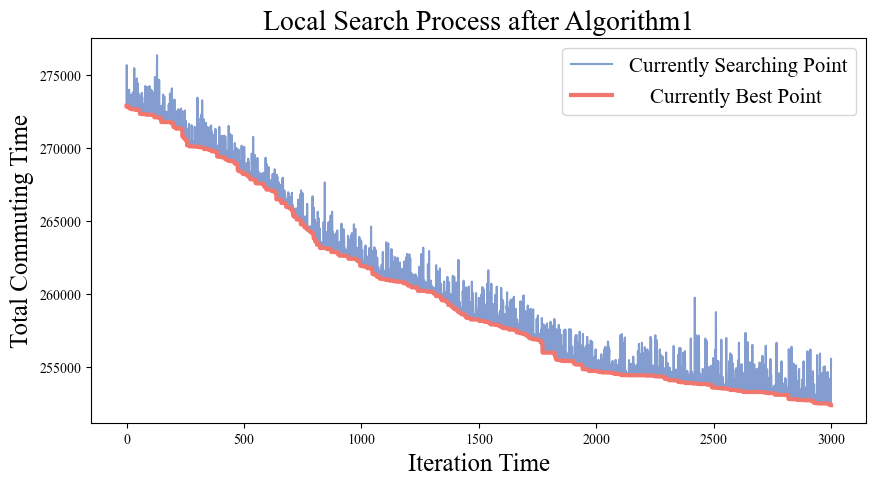

In [132]:
plt.figure(figsize=(10,5))
plt.plot(df_SA_process1['0'],label='Currently Searching Point',color='#839DD1')
plt.plot(lowerbound(df_SA_process1['0']), label='    Currently Best Point  ',linewidth=3,color='#F1766D')
plt.legend(fontsize=15)
plt.xlabel('Iteration Time',fontsize=18)
plt.ylabel('Total Commuting Time',fontsize=18)
plt.title('Local Search Process after Algorithm1',fontsize=20)


Text(0.5, 1.0, 'Local Search Process after Algorithm2')

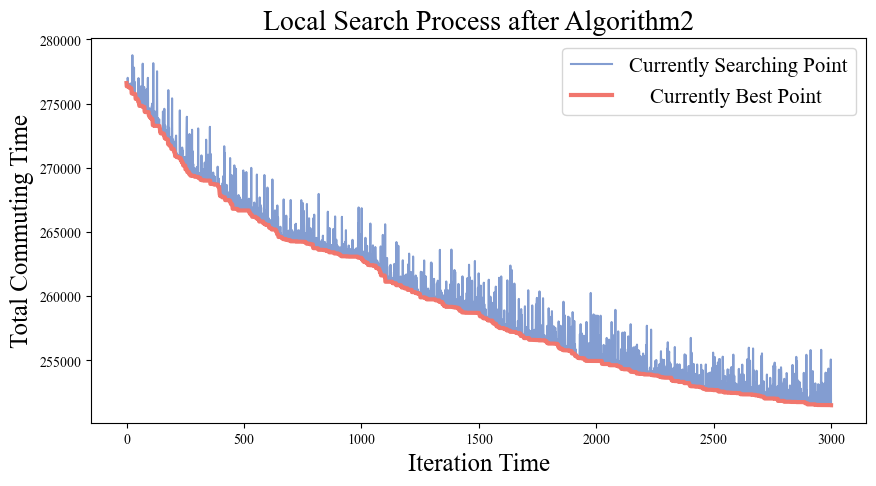

In [133]:
plt.figure(figsize=(10,5))
plt.plot(df_SA_process2['0'],label='Currently Searching Point',color='#839DD1')
plt.plot(lowerbound(df_SA_process2['0']), label='    Currently Best Point  ',linewidth=3,color='#F1766D')
plt.legend(fontsize=15)
plt.xlabel('Iteration Time',fontsize=18)
plt.ylabel('Total Commuting Time',fontsize=18)
plt.title('Local Search Process after Algorithm2',fontsize=20)

Text(0.5, 1.0, 'Local Search Process after Algorithm3')

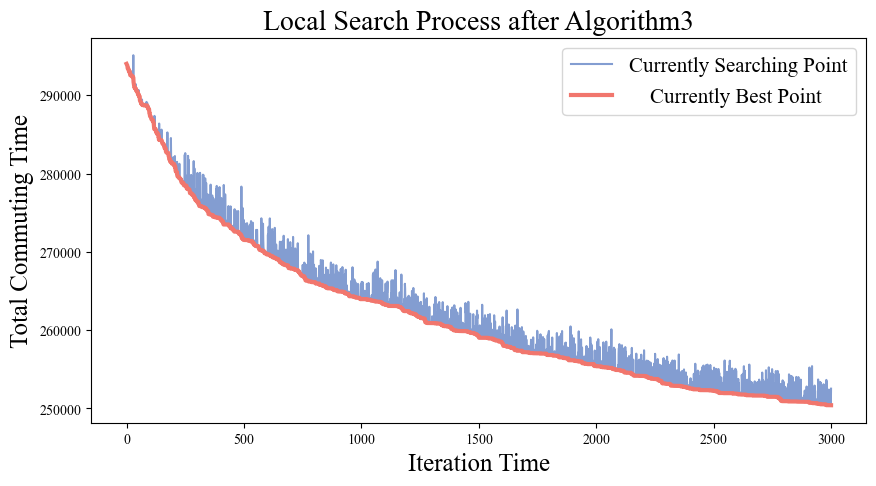

In [136]:
plt.figure(figsize=(10,5))
plt.plot(df_SA_process3['0'],label='Currently Searching Point',color='#839DD1')
plt.plot(lowerbound(df_SA_process3['0']), label='    Currently Best Point  ',linewidth=3,color='#F1766D')

plt.legend(fontsize=15)
plt.xlabel('Iteration Time',fontsize=18)
plt.ylabel('Total Commuting Time',fontsize=18)
plt.title('Local Search Process after Algorithm3',fontsize=20)

Text(0.5, 1.0, 'Local Search Process')

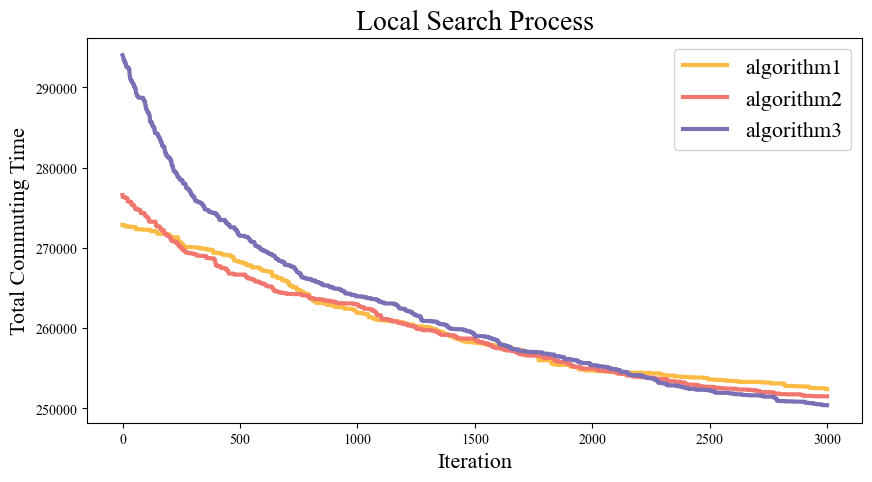

In [145]:
plt.figure(figsize=(10,5))
plt.plot(lowerbound(df_SA_process1['0']), linewidth=3,color='#FCBB44',label='algorithm1')
plt.plot(lowerbound(df_SA_process2['0']), linewidth=3,color='#F1766D',label='algorithm2')
plt.plot(lowerbound(df_SA_process3['0']), linewidth=3,color='#7A70B5',label='algorithm3')
plt.legend(fontsize=16)
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Total Commuting Time',fontsize=16)
plt.title('Local Search Process',fontsize=20)



### 改进算法的跳站分析

算法一：

In [71]:
df_schedule1.iloc[train_N:,stations_N*2:-1].sum().sum()/(len(df_schedule1)-train_N)

43.395833333333336

In [73]:
df_schedule_SA1.iloc[train_N:,stations_N*2:-1].sum().sum()/(len(df_schedule_SA1)-train_N)

40.37

算法二：

In [74]:
df_schedule2.iloc[train_N:,stations_N*2:-1].sum().sum()/(len(df_schedule2)-train_N)

42.375

In [75]:
df_schedule_SA2.iloc[train_N:,stations_N*2:-1].sum().sum()/(len(df_schedule_SA2)-train_N)

38.82

算法三：

In [77]:
df_schedule3.iloc[train_N:,stations_N*2:-1].sum().sum()/(len(df_schedule3)-train_N)

50.0

In [80]:
df_schedule_SA3.iloc[train_N:,stations_N*2:-1].sum().sum()/(len(df_schedule_SA3)-train_N)

41.505050505050505